In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle

# pandasの表示を設定するよ
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

In [40]:
def rmsle(y_true, y_pred):

    return np.sqrt(msle(y_true, y_pred))

### それぞれ個別に求めたトレンド、周期性、残差を合計して最終的な予測値とする

In [41]:
df = pd.read_csv('train_features_added.csv')
submit_base = pd.read_csv('sample_submission.csv')

df_trend = pd.read_csv('trend.csv')
df_seasonal = pd.read_csv('seasonal.csv')
df_resid = pd.read_csv('resid.csv')

df_trend_val = pd.read_csv('trend_val.csv')
df_seasonal_val = pd.read_csv('seasonal_val.csv')
df_resid_val = pd.read_csv('resid_val.csv')

In [42]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
target_names = ['CO', 'C6H6', 'NOx']

In [43]:
integrated_CO = (df_trend['trend_CO'] + df_seasonal['seasonal_CO'] + df_resid['resid_CO']).clip(0)
integrated_C6H6 = (df_trend['trend_C6H6'] + df_seasonal['seasonal_C6H6'] + df_resid['resid_C6H6']).clip(0)
integrated_NOx = (df_trend['trend_NOx'] + df_seasonal['seasonal_NOx'] + df_resid['resid_NOx']).clip(0)

integrated_CO_val = (df_trend_val['val_trend_CO'] + df_seasonal_val['val_seasonal_CO'] + df_resid_val['val_resid_CO']).clip(0)
integrated_C6H6_val = (df_trend_val['val_trend_C6H6'] + df_seasonal_val['val_seasonal_C6H6'] + df_resid_val['val_resid_C6H6']).clip(0)
integrated_NOx_val = (df_trend_val['val_trend_NOx'] + df_seasonal_val['val_seasonal_NOx'] + df_resid_val['val_resid_NOx']).clip(0)

In [44]:
submit_base[targets[0]] = integrated_CO
submit_base[targets[1]] = integrated_C6H6
submit_base[targets[2]] = integrated_NOx

In [45]:
def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df


df = format_date_time(df)
submit_base = format_date_time(submit_base)

df_train, df_val = train_test_split(df, test_size=0.2, shuffle=False)

In [46]:
rmsle_CO = rmsle(df_val[targets[0]], integrated_CO_val)
rmsle_C6H6 = rmsle(df_val[targets[1]], integrated_C6H6_val)
rmsle_NOx = rmsle(df_val[targets[2]], integrated_NOx_val)

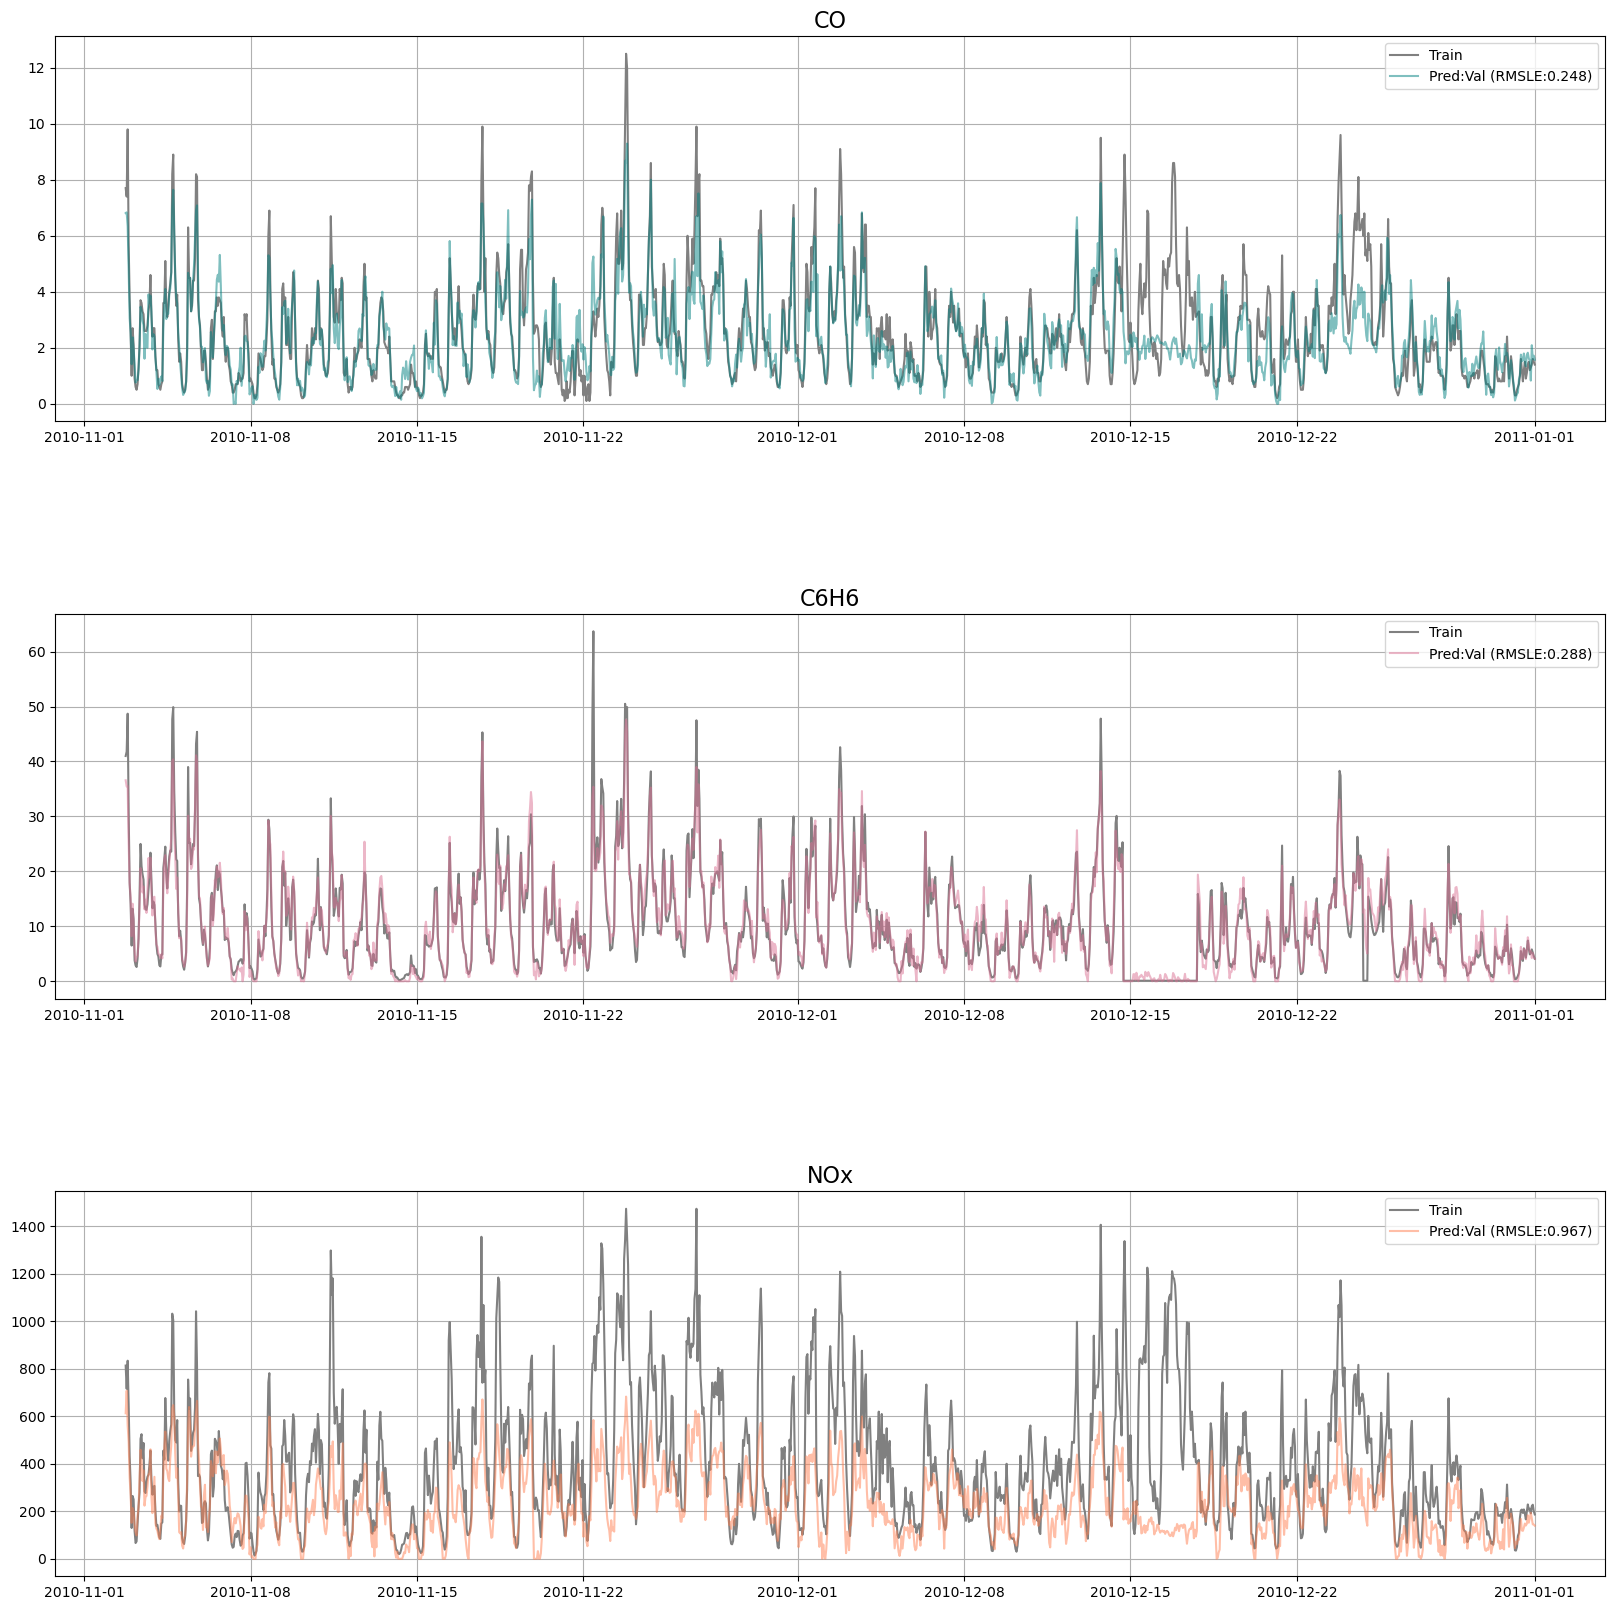

In [47]:
colors = ['teal', 'palevioletred', 'coral']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'integrated_{target_names[i]}_val'
    name2 = f'rmsle_{target_names[i]}'

    axs[i].plot(df_val['date_time'], df_val[targets[i]], color='gray', label='Train')
    axs[i].plot(df_val['date_time'], globals()[name1], color=colors[i], alpha=0.5, label=f'Pred:Val (RMSLE:{globals()[name2]:.3f})')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

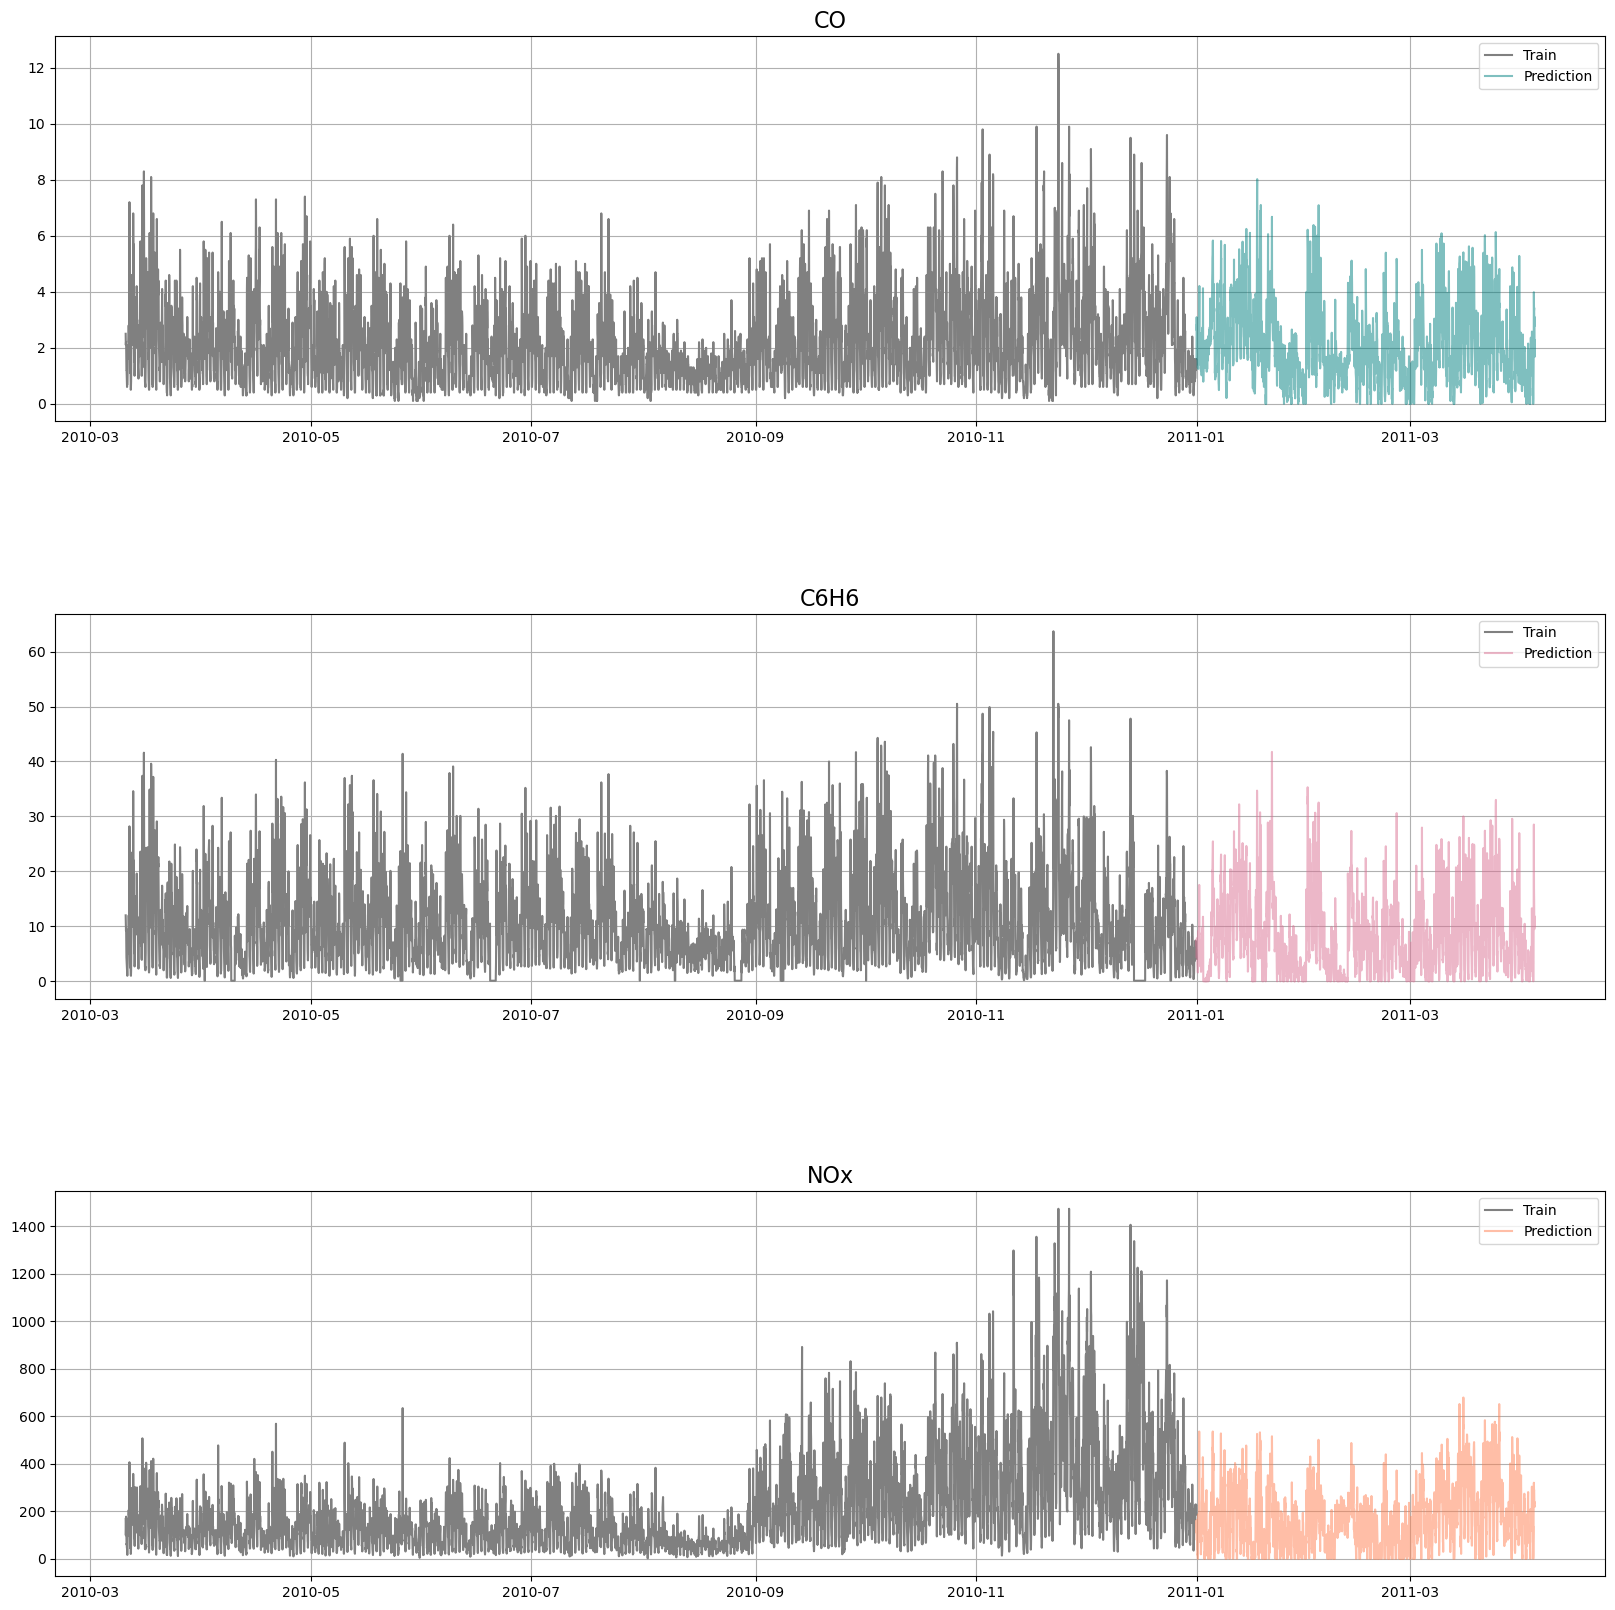

In [48]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    axs[i].plot(df['date_time'], df[targets[i]], color='gray', label='Train')
    axs[i].plot(submit_base['date_time'], submit_base[targets[i]], color=colors[i], alpha=0.5, label='Prediction')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

In [49]:
submit_base.to_csv('submission_STL_reintegrated.csv', index=False)